In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/BE Project/FBHM.zip", 'r')
files.extractall('memes')
files.close()

In [ ]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/BE Project/Test.zip", 'r')
files.extractall('testmemes')
files.close()

In [9]:
pip install transformers torch torchvision tqdm


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import LxmertTokenizer, LxmertModel
from PIL import Image
from torchvision import models, transforms
import json
import os
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ToxicMemeDataset(Dataset):
    def __init__(self, json_file, img_dir, tokenizer, max_len, transform=None):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Text processing
        text = item["text"]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Image processing
        img_path = os.path.join(self.img_dir, item["img"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(item["label"], dtype=torch.long)

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image,
            "label": label,
        }

# Model Definition
class ToxicMemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ToxicMemeClassifier, self).__init__()
        self.lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")

        # Add a ResNet backbone for visual feature extraction
        resnet = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.visual_fc = nn.Linear(resnet.fc.in_features, self.lxmert.config.visual_feat_dim)

        # Classifier
        self.fc = nn.Linear(self.lxmert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Extract visual features
        visual_feats = self.cnn_backbone(images).squeeze(-1).squeeze(-1)  # (batch_size, 2048)
        visual_feats = self.visual_fc(visual_feats)  # (batch_size, visual_feat_dim)

        # Create a dummy visual_pos tensor
        visual_pos = torch.zeros(visual_feats.size(0), 1, 4).to(visual_feats.device)

        # LXMERT forward pass
        outputs = self.lxmert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_feats=visual_feats.unsqueeze(1),  # Add the region dimension
            visual_pos=visual_pos,
        )
        logits = self.fc(outputs.pooled_output)
        return logits


# Training Function
def train_model(model, data_loader, optimizer, criterion, device, epochs):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        loop = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(data_loader)}")

# Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Accuracy: {correct / total:.2f}")

# Main Script
if __name__ == "__main__":
    # Paths
    json_file = "/content/dataset1.json"
    img_dir = "/content/memes/FBHM/data/img"

    # Hyperparameters
    max_len = 128
    batch_size = 20
    learning_rate = 1e-5
    epochs = 10

    # Tokenizer and Transform
    tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Dataset and DataLoader
    dataset = ToxicMemeDataset(json_file, img_dir, tokenizer, max_len, transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model, Loss, Optimizer
    model = ToxicMemeClassifier(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, optimizer, criterion, device, epochs)
    evaluate_model(model, test_loader, device)


AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

In [ ]:
def test_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Get model predictions
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2f}")

    return all_preds, all_labels


In [ ]:
class ToxicMemeDataset(Dataset):
    def __init__(self, json_file, img_dir, tokenizer, max_len, transform=None):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Text processing
        text = item["text"]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Image processing
        img_path = os.path.join(self.img_dir, item["img"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Label (You might want to set this for testing if it's available)
        label = torch.tensor(item.get("label", 0), dtype=torch.long)  # If labels are not in the test set, set default to 0

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image,
            "label": label,
        }


In [ ]:
# Paths for your testing data
test_json_file = "/content/drive/MyDrive/BE Project/new test.json"
test_img_dir = "/content/testmemes/Test"

# Tokenizer and transformations (same as training)
tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load test dataset and DataLoader
test_dataset = ToxicMemeDataset(test_json_file, test_img_dir, tokenizer, max_len=128, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16)


In [ ]:
# Test the model on the new test dataset
test_preds, test_labels = test_model(model, test_loader, device)


Test Accuracy: 0.00


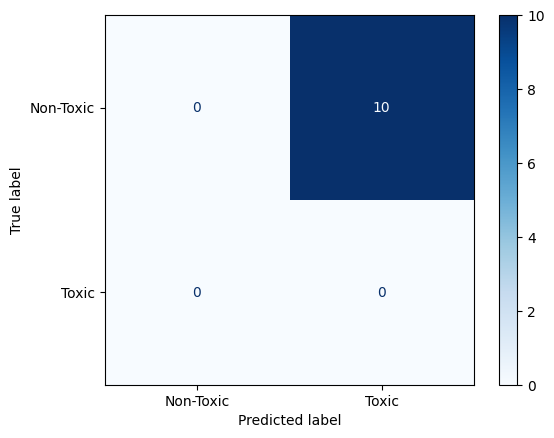

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Toxic", "Toxic"])
disp.plot(cmap="Blues")


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, test_preds, target_names=["Non-Toxic", "Toxic"]))


              precision    recall  f1-score   support

   Non-Toxic       0.00      0.00      0.00      10.0
       Toxic       0.00      0.00      0.00       0.0

    accuracy                           0.00      10.0
   macro avg       0.00      0.00      0.00      10.0
weighted avg       0.00      0.00      0.00      10.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
for i in range(5):  # Display 5 sample predictions
    #(f"Text: {test_dataset[i]['text']}")
    print(f"True Label: {'Toxic' if test_labels[i] == 1 else 'Non-Toxic'}")
    print(f"Predicted Label: {'Toxic' if test_preds[i] == 1 else 'Non-Toxic'}")
    print("-" * 50)



True Label: Non-Toxic
Predicted Label: Toxic
--------------------------------------------------
True Label: Non-Toxic
Predicted Label: Toxic
--------------------------------------------------
True Label: Non-Toxic
Predicted Label: Toxic
--------------------------------------------------
True Label: Non-Toxic
Predicted Label: Toxic
--------------------------------------------------
True Label: Non-Toxic
Predicted Label: Toxic
--------------------------------------------------


In [11]:
pip install torch

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import LxmertTokenizer, LxmertModel
from PIL import Image
from torchvision import transforms
import json
import os
from tqdm import tqdm


AttributeError: partially initialized module 'torch' has no attribute 'version' (most likely due to a circular import)

In [17]:
!pip uninstall torch



Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchfrtrace
    /usr/local/bin/torchrun
    /usr/local/lib/python3.11/dist-packages/functorch/*
    /usr/local/lib/python3.11/dist-packages/torch-2.5.1+cu121.dist-info/*
    /usr/local/lib/python3.11/dist-packages/torch/*
    /usr/local/lib/python3.11/dist-packages/torchgen/*
Proceed (Y/n)? y
  Successfully uninstalled torch-2.5.1+cu121


In [18]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 775.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 805.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!ls


dataset22.json	drive  memes  sample_data


In [3]:
!rm -rf __pycache__
!pip cache purge


Files removed: 24


In [4]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.5.1+cu118
CUDA available: True


In [5]:
from transformers import LxmertModel, LxmertTokenizer
LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")


RuntimeError: Failed to import transformers.models.lxmert.modeling_lxmert because of the following error (look up to see its traceback):
Detected that PyTorch and torchvision were compiled with different CUDA major versions. PyTorch has CUDA Version=11.8 and torchvision has CUDA Version=12.1. Please reinstall the torchvision that matches your PyTorch install.

In [6]:
!pip uninstall -y torch torchvision torchaudio


Found existing installation: torch 2.5.1+cu118
Uninstalling torch-2.5.1+cu118:
  Successfully uninstalled torch-2.5.1+cu118
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121


In [7]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 709.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.1 MB/s eta 0:00:00


In [1]:
import torch
import torchvision
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())


Torch version: 2.5.1+cu118
Torchvision version: 0.20.1+cu118
CUDA available: True


In [2]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [3]:
from transformers import LxmertModel, LxmertTokenizer
LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some weights of the model checkpoint at unc-nlp/lxmert-base-uncased were not used when initializing LxmertModel: ['answer_head.logit_fc.0.bias', 'answer_head.logit_fc.0.weight', 'answer_head.logit_fc.2.bias', 'answer_head.logit_fc.2.weight', 'answer_head.logit_fc.3.bias', 'answer_head.logit_fc.3.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'obj_predict_head.decoder_dict.attr.bias', 'obj_predict_head.decoder_dict.attr.weight', 'obj_predict_head.decoder_dict.feat.bias', 'obj_predict_head.decoder_dict.feat.weight', 'obj_predict_head.decoder_dict.obj.bias', 'obj_predict_head.decoder_dict.obj.weight', 'obj_predict_head.transform.LayerNorm.bias', 'obj_predict_head.transform.LayerNorm.weight', 'obj_predict_head.transform.dense.bias', 'obj_pred

tokenizer_config.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

LxmertTokenizer(name_or_path='unc-nlp/lxmert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import LxmertTokenizer, LxmertModel
from PIL import Image
from torchvision import transforms
import json
import os
from tqdm import tqdm


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class ToxicMemeDataset(Dataset):
    def __init__(self, json_file, img_dir, tokenizer, max_len, transform=None):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Text processing
        text = item["text"]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Image processing
        img_path = os.path.join(self.img_dir, item["img"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(item["label"], dtype=torch.long)

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image,
            "label": label,
        }


In [7]:
class ToxicMemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ToxicMemeClassifier, self).__init__()
        self.lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")
        self.fc = nn.Linear(self.lxmert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, visual_feats, visual_pos):
        outputs = self.lxmert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_feats=visual_feats,
            visual_pos=visual_pos,
        )
        logits = self.fc(outputs.pooled_output)
        return logits


In [8]:
def train_model(model, data_loader, optimizer, criterion, device, epochs):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        loop = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            visual_feats = images  # Use pre-extracted features for images (optional)
            visual_pos = torch.zeros_like(visual_feats[:, :4])  # Placeholder
            outputs = model(input_ids, attention_mask, visual_feats, visual_pos)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(data_loader)}")


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import LxmertTokenizer, LxmertModel
from PIL import Image
from torchvision import models, transforms
import json
import os
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ToxicMemeDataset(Dataset):
    def __init__(self, json_file, img_dir, tokenizer, max_len, transform=None):
        with open(json_file, "r") as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Text processing
        text = item["text"]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # Image processing
        img_path = os.path.join(self.img_dir, item["img"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Label
        label = torch.tensor(item["label"], dtype=torch.long)

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image,
            "label": label,
        }

# Model Definition
class ToxicMemeClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ToxicMemeClassifier, self).__init__()
        self.lxmert = LxmertModel.from_pretrained("unc-nlp/lxmert-base-uncased")

        # Add a ResNet backbone for visual feature extraction
        resnet = models.resnet50(pretrained=True)
        self.cnn_backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.visual_fc = nn.Linear(resnet.fc.in_features, self.lxmert.config.visual_feat_dim)

        # Classifier
        self.fc = nn.Linear(self.lxmert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Extract visual features
        visual_feats = self.cnn_backbone(images).squeeze(-1).squeeze(-1)  # (batch_size, 2048)
        visual_feats = self.visual_fc(visual_feats).unsqueeze(1)  # Add region dimension (batch_size, 1, visual_feat_dim)

        # Create a dummy visual_pos tensor
        batch_size = visual_feats.size(0)
        visual_pos = torch.zeros(batch_size, 1, 4).to(visual_feats.device)  # One region per image

        # LXMERT forward pass
        outputs = self.lxmert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            visual_feats=visual_feats,
            visual_pos=visual_pos,
        )
        logits = self.fc(outputs.pooled_output)
        return logits

# Training Function
def train_model(model, data_loader, optimizer, criterion, device, epochs):
    model = model.to(device)
    for epoch in range(epochs):
        model.train()
        loop = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(data_loader)}")

# Evaluation Function
def evaluate_model(model, data_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Accuracy: {correct / total:.2f}")

# Main Script
if __name__ == "__main__":
    # Paths
    json_file = "/content/dataset22.json"
    img_dir = "/content/memes/FBHM/data/img"

    # Hyperparameters
    max_len = 128
    batch_size = 16
    learning_rate = 1e-5
    epochs = 5

    # Tokenizer and Transform
    tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Dataset and DataLoader
    dataset = ToxicMemeDataset(json_file, img_dir, tokenizer, max_len, transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model, Loss, Optimizer
    model = ToxicMemeClassifier(num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Train and Evaluate
    train_model(model, train_loader, optimizer, criterion, device, epochs)
    evaluate_model(model, test_loader, device)


Some weights of the model checkpoint at unc-nlp/lxmert-base-uncased were not used when initializing LxmertModel: ['answer_head.logit_fc.0.bias', 'answer_head.logit_fc.0.weight', 'answer_head.logit_fc.2.bias', 'answer_head.logit_fc.2.weight', 'answer_head.logit_fc.3.bias', 'answer_head.logit_fc.3.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'obj_predict_head.decoder_dict.attr.bias', 'obj_predict_head.decoder_dict.attr.weight', 'obj_predict_head.decoder_dict.feat.bias', 'obj_predict_head.decoder_dict.feat.weight', 'obj_predict_head.decoder_dict.obj.bias', 'obj_predict_head.decoder_dict.obj.weight', 'obj_predict_head.transform.LayerNorm.bias', 'obj_predict_head.transform.LayerNorm.weight', 'obj_predict_head.transform.dense.bias', 'obj_pred

Epoch 1: Loss = 0.6290622642460991


Epoch 2/5: 100%|██████████| 425/425 [06:31<00:00,  1.09it/s, loss=0.466]


Epoch 2: Loss = 0.5469955149468254


Epoch 3/5: 100%|██████████| 425/425 [06:21<00:00,  1.11it/s, loss=0.472]


Epoch 3: Loss = 0.40039686523816165


Epoch 4/5: 100%|██████████| 425/425 [06:18<00:00,  1.12it/s, loss=0.194]


Epoch 4: Loss = 0.23930150749052273


Epoch 5/5: 100%|██████████| 425/425 [06:21<00:00,  1.11it/s, loss=0.0724]


Epoch 5: Loss = 0.14982424445450307
Accuracy: 0.66


In [11]:
def test_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            # Get model predictions
            outputs = model(input_ids, attention_mask, images)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.2f}")

    return all_preds, all_labels


In [12]:
# Test the model on the test dataset
test_preds, test_labels = test_model(model, test_loader, device)


Test Accuracy: 0.66


In [13]:
torch.save(model.state_dict(), "toxic_meme_classifier.pth")

In [14]:
model.load_state_dict(torch.load("toxic_meme_classifier.pth"))
model.eval()  # Make sure to call eval() before inference

<ipython-input-14-08da9a888559>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("toxic_meme_classifier.pth"))


ToxicMemeClassifier(
  (lxmert): LxmertModel(
    (embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (visn_fc): LxmertVisualFeatureEncoder(
        (visn_fc): Linear(in_features=2048, out_features=768, bias=True)
        (visn_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (box_fc): Linear(in_features=4, out_features=768, bias=True)
        (box_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layer): ModuleList(
        (0-8): 9 x LxmertLayer(
          (attention): LxmertSelfAttentionLayer(
            (self): LxmertAttention(
              (query):

In [15]:
def predict(model, img_path, text, tokenizer, transform, device):
    model = model.to(device)
    # Process text
    encoding = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # Process image
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Model inference
    with torch.no_grad():
        output = model(input_ids, attention_mask, image)
        _, prediction = torch.max(output, dim=1)
        return prediction.item()


In [16]:
pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 kB 26.2 MB/s eta 0:00:00


In [29]:
import easyocr
from PIL import Image

def extract_text_from_image(img_path):
    # Initialize the EasyOCR reader for English
    reader = easyocr.Reader(['en'])

    # Use EasyOCR to extract text from the image
    results = reader.readtext(img_path)

    # Combine all extracted text (if any)
    text = " ".join([result[1] for result in results])

    return text.strip()

# Example usage
img_path = "/content/48106.png"
text = extract_text_from_image(img_path)

# text = ""
print(f"\n Extracted Text: {text}")

# Now predict using the model
prediction = predict(model, img_path, text, tokenizer, transform, device)
print(f"Prediction: {'Toxic' if prediction == 1 else 'Non-toxic'}")



 Extracted Text: fuek isllam
Prediction: Toxic
